In [1]:
import celltypist
from celltypist import models
import scanpy as sc
import pandas as pd 
import numpy as np
import anndata
import re
import h5py
import scipy.sparse as scs
import concurrent.futures
import scanpy.external as sce
import gc
import harmonypy
from concurrent.futures import ThreadPoolExecutor
from concurrent.futures import ProcessPoolExecutor
import matplotlib.pyplot as plt
import copy

# Anndata creation

In [2]:
adata = sc.read_h5ad('/home/jupyter/Myeloid_cells/files/FluYr1D0.h5ad')

In [3]:
adata

AnnData object with n_obs × n_vars = 1542995 × 33538
    obs: 'barcodes', 'batch_id', 'cell_name', 'cell_uuid', 'chip_id', 'hto_barcode', 'hto_category', 'n_genes', 'n_mito_umis', 'n_reads', 'n_umis', 'original_barcodes', 'pbmc_sample_id', 'pool_id', 'seurat_pbmc_type', 'seurat_pbmc_type_score', 'umap_1', 'umap_2', 'well_id', 'subject.biologicalSex', 'subject.ethnicity', 'subject.partnerCode', 'subject.race', 'subject.subjectGuid', 'cohort.cohortGuid', 'sample.visitName', 'sample.visitDetails', 'subject.birthYear', 'CMV.IgG.Serology.Result.Interpretation', 'BMI', 'predicted_doublet', 'doublet_score', 'AIFI_L1', 'AIFI_L2', 'AIFI_L3', 'AIFI_L3.5', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito'

In [5]:
adata.obs['cohort.cohortGuid'].unique()

['BR1', 'BR2']
Categories (2, object): ['BR1', 'BR2']

In [6]:
# Define the cell types you want to subset
selected_cell_types = ['IL1B+ CD14 monocyte']
#selected_cell_types = ['IL1B+ CD14 monocyte']

subset_adata = adata[adata.obs['AIFI_L3'].isin(selected_cell_types), :]
subset_adata.obs['AIFI_L3'].value_counts()

AIFI_L3
IL1B+ CD14 monocyte    2679
Name: count, dtype: int64

In [8]:
subset_adata.raw= subset_adata

In [9]:
subset_adata.obs

,barcodes,batch_id,cell_name,cell_uuid,chip_id,hto_barcode,hto_category,n_genes,n_mito_umis,n_reads,...,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mito,log1p_total_counts_mito,pct_counts_mito
barcodes,,,,,,,,,,,,,,,,,,,,,
cfb4162a48b611ea8957bafe6d70929e,cfb4162a48b611ea8957bafe6d70929e,B001,anaemic_human_emu,cfb4162a48b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,2867,546,32119,...,7.961370,9871.0,9.197457,32.499240,45.182859,55.890994,68.442914,546.0,6.304449,5.531354
70ab258848b611eaa65d9e7d578d66f2,70ab258848b611eaa65d9e7d578d66f2,B001,pine_enervated_caracal,70ab258848b611eaa65d9e7d578d66f2,B001-P1C1,TGATGGCCTATTGGG,singlet,2354,220,27740,...,7.764296,8105.0,9.000360,32.806909,45.909932,57.668106,71.844540,220.0,5.398163,2.714374
70acf29648b611eaa65d9e7d578d66f2,70acf29648b611eaa65d9e7d578d66f2,B001,bland_sandy_owl,70acf29648b611eaa65d9e7d578d66f2,B001-P1C1,TGATGGCCTATTGGG,singlet,4302,776,73872,...,8.367068,21505.0,9.976088,31.597303,45.533597,56.861195,68.774704,776.0,6.655440,3.608463
70d2b34648b611eaa65d9e7d578d66f2,70d2b34648b611eaa65d9e7d578d66f2,B001,mellow_intact_gecko,70d2b34648b611eaa65d9e7d578d66f2,B001-P1C1,TGATGGCCTATTGGG,singlet,2176,167,20037,...,7.685703,6038.0,8.705994,28.800927,40.559788,52.732693,67.803909,167.0,5.123964,2.765816
70d844f048b611eaa65d9e7d578d66f2,70d844f048b611eaa65d9e7d578d66f2,B001,commonable_jadeite_wrenchbird,70d844f048b611eaa65d9e7d578d66f2,B001-P1C1,TGATGGCCTATTGGG,singlet,1977,124,20342,...,7.589842,6027.0,8.704170,34.992534,46.822631,57.789945,72.125436,124.0,4.828314,2.057408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4fcaf786286511ec8c0d4aaa4b9002e8,4fcaf786286511ec8c0d4aaa4b9002e8,B085,unliterary_xerophobic_vulture,4fcaf786286511ec8c0d4aaa4b9002e8,B085-P2C3,ATTGACCCGCGTTAG,singlet,2225,231,19826,...,7.707962,6517.0,8.782323,31.548258,43.271444,54.871874,68.651220,231.0,5.446737,3.544576
ce432b48286411eca744faae388e9f17,ce432b48286411eca744faae388e9f17,B085,sly_fleshy_kitty,ce432b48286411eca744faae388e9f17,B085-P2C3,ATTGACCCGCGTTAG,singlet,2974,472,38175,...,7.997999,10723.0,9.280239,31.092045,42.068451,53.044857,67.322578,472.0,6.159095,4.401753
fbe4aa18286411ecb1698ec288c6fba6,fbe4aa18286411ecb1698ec288c6fba6,B085,topnotch_antelopine_chipmunk,fbe4aa18286411ecb1698ec288c6fba6,B085-P2C3,ATTGACCCGCGTTAG,singlet,1595,192,11363,...,7.375256,4077.0,8.313362,33.750307,45.327447,56.757420,72.921266,192.0,5.262690,4.709345


In [10]:
%%time
sc.pp.normalize_total(subset_adata, target_sum=1e4)

CPU times: user 24.7 ms, sys: 945 µs, total: 25.6 ms
Wall time: 25.3 ms


In [11]:
%%time
sc.pp.log1p(subset_adata)
sc.pp.highly_variable_genes(subset_adata)
subset_adata = subset_adata[:, subset_adata.var_names[subset_adata.var['highly_variable']]]

CPU times: user 519 ms, sys: 63 ms, total: 582 ms
Wall time: 582 ms


In [12]:
sc.pp.scale(subset_adata)

In [13]:
sc.tl.pca(subset_adata, svd_solver='arpack')

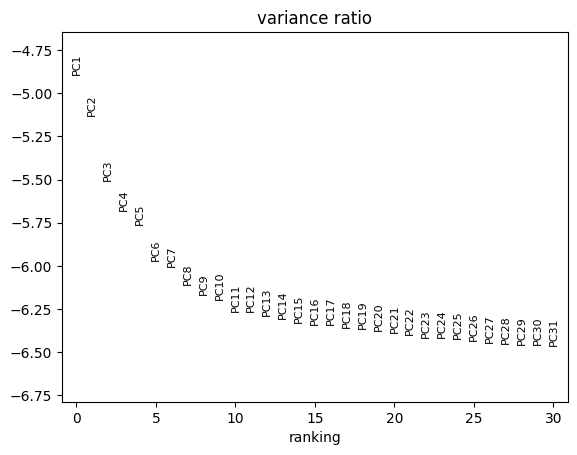

In [14]:
sc.pl.pca_variance_ratio(subset_adata, log=True)

In [15]:
%%time

sce.pp.harmony_integrate(subset_adata, 'cohort.cohortGuid',max_iter_harmony = 30)

2024-04-03 00:48:46,552 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
Computing initial centroids with sklearn.KMeans...
2024-04-03 00:48:48,540 - harmonypy - INFO - sklearn.KMeans initialization complete.
sklearn.KMeans initialization complete.
2024-04-03 00:48:48,556 - harmonypy - INFO - Iteration 1 of 30
Iteration 1 of 30
2024-04-03 00:48:49,086 - harmonypy - INFO - Iteration 2 of 30
Iteration 2 of 30
2024-04-03 00:48:49,606 - harmonypy - INFO - Iteration 3 of 30
Iteration 3 of 30
2024-04-03 00:48:50,145 - harmonypy - INFO - Iteration 4 of 30
Iteration 4 of 30
2024-04-03 00:48:50,679 - harmonypy - INFO - Iteration 5 of 30
Iteration 5 of 30
2024-04-03 00:48:51,211 - harmonypy - INFO - Iteration 6 of 30
Iteration 6 of 30
2024-04-03 00:48:51,576 - harmonypy - INFO - Iteration 7 of 30
Iteration 7 of 30
2024-04-03 00:48:51,905 - harmonypy - INFO - Iteration 8 of 30
Iteration 8 of 30
2024-04-03 00:48:52,204 - harmonypy - INFO - Iteration 9 of 30
Iteration 9 of 30

CPU times: user 2min 52s, sys: 3min 44s, total: 6min 36s
Wall time: 7.16 s


In [16]:
%%time

sc.pp.neighbors(subset_adata, n_neighbors=50,use_rep='X_pca_harmony', n_pcs=30)
sc.tl.umap(subset_adata)

CPU times: user 19.2 s, sys: 9.37 s, total: 28.6 s
Wall time: 12.5 s


In [17]:
subset_adata.write_h5ad('/home/jupyter/Myeloid_cells/files/IL1B_CD14_Mono_ONLY_FluYr1D0_post_harmony.h5ad')

In [18]:
def run_leiden(adata, resolution, key_added):
    # Make a copy of adata for thread safety
    adata_copy = copy.deepcopy(adata)
    adata_clustering = sc.tl.leiden(adata_copy, resolution=resolution, key_added=key_added, copy=True)
    return adata_clustering.obs
 
def run_leiden_parallel(adata, tasks):
    with ProcessPoolExecutor(max_workers=5) as executor:
        # Make deep copies of adata for each task to ensure thread safety
        futures = [executor.submit(run_leiden, copy.deepcopy(adata), resolution, key_added) for resolution, key_added in tasks]
        results = [future.result() for future in futures]
 
    # Assign the results back to the original AnnData object
    for result, (_, key_added) in zip(results, tasks):
        adata.obs[key_added] = result[key_added]
 
    return adata

In [19]:
%%time


tasks = [(0.5, "leiden_resolution_0.5"),(1, "leiden_resolution_1"),(1.5, "leiden_resolution_1.5"),(2, "leiden_resolution_2")]
subset_adata = run_leiden_parallel(subset_adata, tasks)

CPU times: user 254 ms, sys: 3.7 s, total: 3.96 s
Wall time: 9.89 s


In [20]:
subset_adata.write_h5ad('/home/jupyter/Myeloid_cells/files/IL1B_CD14_Mono_ONLY_FluYr1D0_parallel.h5ad')

In [21]:
subset_adata

AnnData object with n_obs × n_vars = 2679 × 2686
    obs: 'barcodes', 'batch_id', 'cell_name', 'cell_uuid', 'chip_id', 'hto_barcode', 'hto_category', 'n_genes', 'n_mito_umis', 'n_reads', 'n_umis', 'original_barcodes', 'pbmc_sample_id', 'pool_id', 'seurat_pbmc_type', 'seurat_pbmc_type_score', 'umap_1', 'umap_2', 'well_id', 'subject.biologicalSex', 'subject.ethnicity', 'subject.partnerCode', 'subject.race', 'subject.subjectGuid', 'cohort.cohortGuid', 'sample.visitName', 'sample.visitDetails', 'subject.birthYear', 'CMV.IgG.Serology.Result.Interpretation', 'BMI', 'predicted_doublet', 'doublet_score', 'AIFI_L1', 'AIFI_L2', 'AIFI_L3', 'AIFI_L3.5', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'leiden_resolution_0.5', 'leiden_resolution_1', 'leiden_resolution_1.5', '

In [33]:
adata = sc.read_h5ad('/home/jupyter/Myeloid_cells/files/IL1B_CD14_Mono_ONLY_FluYr1D0_parallel.h5ad')

In [37]:
obs = adata.obs

In [38]:
obs

,barcodes,batch_id,cell_name,cell_uuid,chip_id,hto_barcode,hto_category,n_genes,n_mito_umis,n_reads,...,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mito,log1p_total_counts_mito,pct_counts_mito,leiden_resolution_0.5,leiden_resolution_1,leiden_resolution_1.5,leiden_resolution_2
barcodes,,,,,,,,,,,,,,,,,,,,,
cfb4162a48b611ea8957bafe6d70929e,cfb4162a48b611ea8957bafe6d70929e,B001,anaemic_human_emu,cfb4162a48b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,2867,546,32119,...,45.182859,55.890994,68.442914,546.0,6.304449,5.531354,1,0,1,7
70ab258848b611eaa65d9e7d578d66f2,70ab258848b611eaa65d9e7d578d66f2,B001,pine_enervated_caracal,70ab258848b611eaa65d9e7d578d66f2,B001-P1C1,TGATGGCCTATTGGG,singlet,2354,220,27740,...,45.909932,57.668106,71.844540,220.0,5.398163,2.714374,0,1,3,0
70acf29648b611eaa65d9e7d578d66f2,70acf29648b611eaa65d9e7d578d66f2,B001,bland_sandy_owl,70acf29648b611eaa65d9e7d578d66f2,B001-P1C1,TGATGGCCTATTGGG,singlet,4302,776,73872,...,45.533597,56.861195,68.774704,776.0,6.655440,3.608463,1,5,8,6
70d2b34648b611eaa65d9e7d578d66f2,70d2b34648b611eaa65d9e7d578d66f2,B001,mellow_intact_gecko,70d2b34648b611eaa65d9e7d578d66f2,B001-P1C1,TGATGGCCTATTGGG,singlet,2176,167,20037,...,40.559788,52.732693,67.803909,167.0,5.123964,2.765816,1,0,7,8
70d844f048b611eaa65d9e7d578d66f2,70d844f048b611eaa65d9e7d578d66f2,B001,commonable_jadeite_wrenchbird,70d844f048b611eaa65d9e7d578d66f2,B001-P1C1,TGATGGCCTATTGGG,singlet,1977,124,20342,...,46.822631,57.789945,72.125436,124.0,4.828314,2.057408,0,1,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4fcaf786286511ec8c0d4aaa4b9002e8,4fcaf786286511ec8c0d4aaa4b9002e8,B085,unliterary_xerophobic_vulture,4fcaf786286511ec8c0d4aaa4b9002e8,B085-P2C3,ATTGACCCGCGTTAG,singlet,2225,231,19826,...,43.271444,54.871874,68.651220,231.0,5.446737,3.544576,0,4,2,11
ce432b48286411eca744faae388e9f17,ce432b48286411eca744faae388e9f17,B085,sly_fleshy_kitty,ce432b48286411eca744faae388e9f17,B085-P2C3,ATTGACCCGCGTTAG,singlet,2974,472,38175,...,42.068451,53.044857,67.322578,472.0,6.159095,4.401753,1,0,0,6
fbe4aa18286411ecb1698ec288c6fba6,fbe4aa18286411ecb1698ec288c6fba6,B085,topnotch_antelopine_chipmunk,fbe4aa18286411ecb1698ec288c6fba6,B085-P2C3,ATTGACCCGCGTTAG,singlet,1595,192,11363,...,45.327447,56.757420,72.921266,192.0,5.262690,4.709345,1,9,6,12


In [41]:
obs.to_csv("/home/jupyter/IH-A-Aging-Analysis-Notebooks_old/Mansi_Notebooks/scRNA/Frequency_Plot/Il1B_Cd14_mono_obsdata.csv", index= False)

In [34]:
adata

AnnData object with n_obs × n_vars = 2679 × 2686
    obs: 'barcodes', 'batch_id', 'cell_name', 'cell_uuid', 'chip_id', 'hto_barcode', 'hto_category', 'n_genes', 'n_mito_umis', 'n_reads', 'n_umis', 'original_barcodes', 'pbmc_sample_id', 'pool_id', 'seurat_pbmc_type', 'seurat_pbmc_type_score', 'umap_1', 'umap_2', 'well_id', 'subject.biologicalSex', 'subject.ethnicity', 'subject.partnerCode', 'subject.race', 'subject.subjectGuid', 'cohort.cohortGuid', 'sample.visitName', 'sample.visitDetails', 'subject.birthYear', 'CMV.IgG.Serology.Result.Interpretation', 'BMI', 'predicted_doublet', 'doublet_score', 'AIFI_L1', 'AIFI_L2', 'AIFI_L3', 'AIFI_L3.5', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'leiden_resolution_0.5', 'leiden_resolution_1', 'leiden_resolution_1.5', '

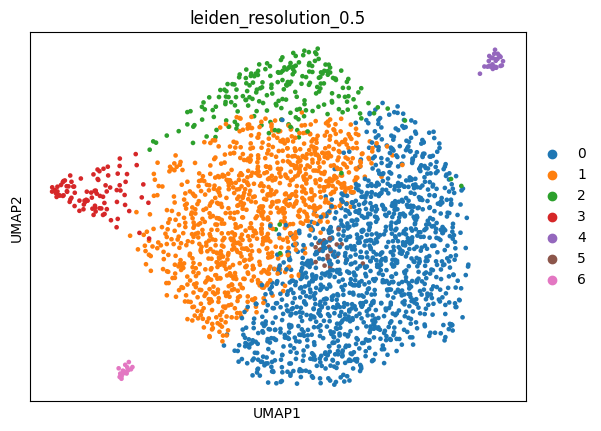

In [42]:
sc.pl.umap(adata, color=['leiden_resolution_0.5'])

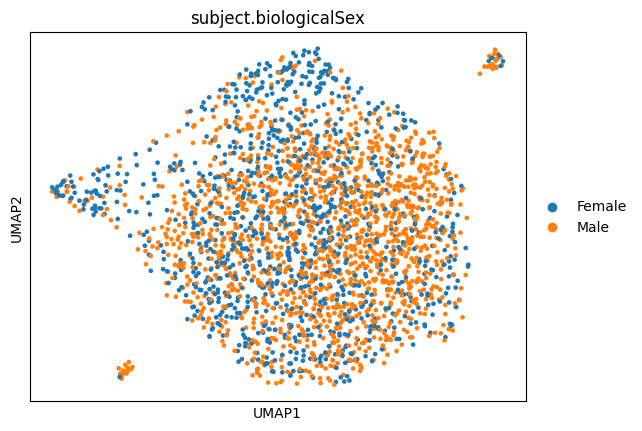

In [27]:
sc.pl.umap(adata, color=['subject.biologicalSex'])

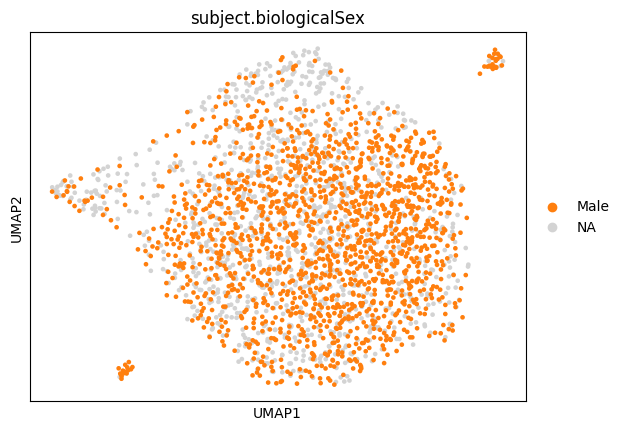

In [28]:
sc.pl.umap(adata, color = "subject.biologicalSex", groups = "Male")

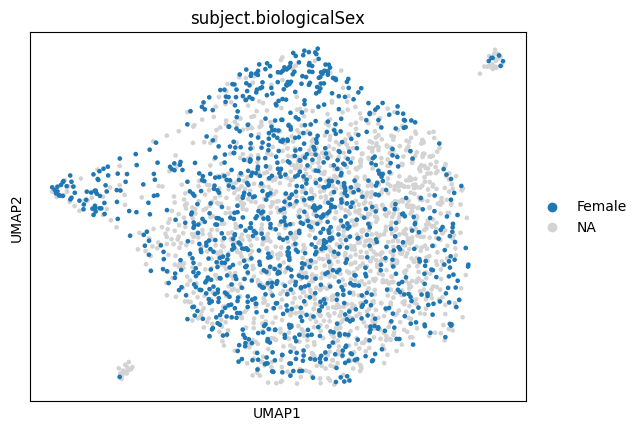

In [32]:
sc.pl.umap(adata, color = "subject.biologicalSex", groups = "Female")

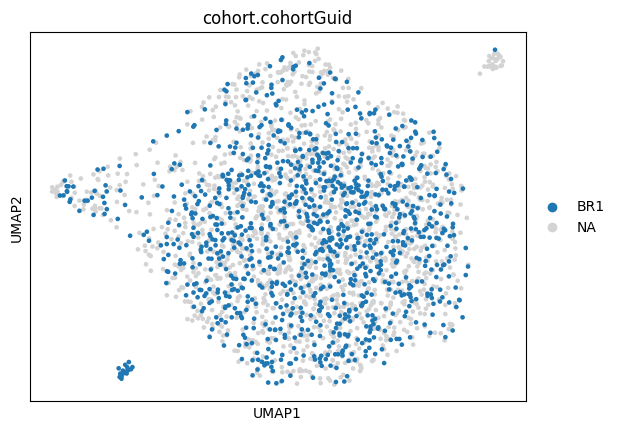

In [30]:
sc.pl.umap(adata, color = "cohort.cohortGuid", groups = "BR1")

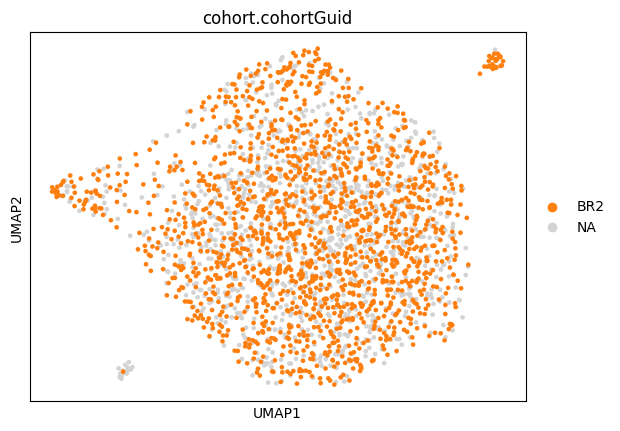

In [31]:
sc.pl.umap(adata, color = "cohort.cohortGuid", groups = "BR2")